In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

from PyPDF2 import PdfFileWriter, PdfFileReader
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

pdfmetrics.registerFont(TTFont('Arial', 'Arial.ttf'))

from sklearn.decomposition import PCA
import umap

from Modules import plot_ax_violin
from Modules import map_to_embeddings

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def read_lin_data():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_labels.index.isin(df.columns)]
    df_labels.sort_values('Age', inplace=True)
    df = np.log2(1+df.loc[:,df_labels.index])
    
    fname = 'Datasets/Lab_Pvalb-Age-Predictions.tsv'
    df_predict = pd.read_csv(fname, **kwargs)
    df_predict = df_predict.loc[df_labels.index,:].iloc[:,1:].copy()
    
    return df, df_labels, df_predict

def generate_random_color():
    numbers = np.random.randint(0,256,3)
    hexes = ['%02s' % hex(number)[2:].upper() for number in numbers]
    
    color = '#' + ''.join(hexes).replace(' ', '0')
    
    return color

def get_homoglobin_data(df_lin, df_labels):
    genes = ['Hba-a1', 'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Hp', 'Mb', 'Ngb', 'Cygb', 'Gh', ][::-1]
    
    genes = ['Hba-a1', 'Hba-a2', 'Hbb-bs',
             'Hbb-bt', 'Hp', 'Mb',
             'Ngb', 'Cygb', 'Gh', 'Gata1',
             'Gata2', 'Gata3', 'Gata4',
             'Gata5', 'Gata6', 'Klf1',
             'Bcl11a', 'Zfpm1', 'Ccne2',
             'Hif1a', 'Hif1an', 'Igf1'
            ]
    gene_colors = {gene:generate_random_color() for gene in genes}
    df_labels = df_labels.loc[df_labels['Morph-PV-types'].isin(('vBC',))]
    df_lin = df_lin.loc[genes,df_labels.index]
    df_age = df_lin.groupby(df_labels.Age, axis=1).mean()
    
    return df_lin, df_age, gene_colors

def get_data():
    df_lin, df_labels, df_predict = read_lin_data()
    df_hemo, df_age, gene_colors = get_homoglobin_data(df_lin, df_labels)
    
    return df_age, gene_colors

def get_age_data():
    df, df_labels, df_predict = read_lin_data()
    kept = df_labels['Morph-PV-types'] == 'vBC'
    df = df.loc[:,kept].copy()
    df_labels = df_labels.loc[kept,:]
    df.columns = df_labels.Age
    
    df.sort_index(axis=1, inplace=True)
    
    return df

def get_gini_genes(cutoff=.10):
    fname = 'Gini Monte Carlo/Gene Scores.tsv'
    df_scores = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df_scores = df_scores.loc[df_scores.P_Adj <= cutoff]
    df_scores.sort_values(['Up_Down', 'Cutoff_Age'], ascending=False, inplace=True)
    
    return df_scores.index.tolist()

def get_monocle_genes():
    fname = 'Datasets/Lab_Pvalb-vBC-Monocle-genes_2.tsv'
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    return genes

def generate_figure():
    fig = plt.figure(figsize=(8.5,11))
    fig.suptitle('Figure 5', fontsize=14, y=.93)
    
    kwargs = {'fontsize':14, 'horizontalalignment':'left', 'verticalalignment':'top'}
    fig.text(.1, .6, 'G', **kwargs)
    fig.text(.7, .6, 'H', **kwargs)
    fig.text(.1, .415, 'I', **kwargs)
    fig.text(.47, .415, 'J', **kwargs)
    fig.text(.665, .415, 'K', **kwargs)
    fig.text(.1, .25, 'L', **kwargs)
    fig.text(.33, .25, 'M', **kwargs)
    fig.text(.51, .25, 'N', **kwargs)
    fig.text(.70, .25, 'O', **kwargs)
    
    return fig

def plot_age_scale(ages, ax):
    age_dist = np.unique(ages)
    datalist = np.linspace(0,1,age_dist.size)[np.newaxis,:]
    pcol = ax.pcolor(datalist, vmin=0, vmax=1, cmap=mpl.cm.bwr)
    pcol.set_edgecolor('face')
    ax.axis([0,datalist.shape[1],0,1])
    ax.set_yticks([])
    
    age_labels = [age_dist.min(), 19, 27, age_dist.max()]
    inds = [.5, np.searchsorted(age_dist, 19), np.searchsorted(age_dist,27), age_dist.size-.5]
    ax.set_xticks(inds)
    ax.set_xticklabels(age_labels, fontsize=5)
    ax.tick_params(size=1, pad=1)
    ax.set_ylabel('Age (days)', fontsize=6, rotation=0, ha='right', va='center')
    
    return

def get_age_colors(ages):
    age_dist = np.unique(ages)
    colors = mpl.cm.bwr(np.linspace(0,1,age_dist.size))
    color_dict = {age:mpl.colors.rgb2hex(color) for age, color in zip(age_dist, colors)}
    
    return np.array([color_dict[age] for age in ages])

def do_genes_pca(df, ax, cax, method='gini'):
    assert method.lower() in ('gini', 'monocle')
    
    if method.lower() == 'gini':
        sig_genes = get_gini_genes()
    else:
        sig_genes = get_monocle_genes()
    df = df.loc[sig_genes]
    if method.lower() == 'gini':
        df = (df>.58).astype(int)
    
    datalist = df.values.T
    #reducer = umap.UMAP(n_components=2, n_neighbors=7, min_dist=.01, random_state=42, metric='euclidean')
    plotlist = PCA(n_components=2).fit_transform(datalist)
    colors = get_age_colors(df.columns.values)
    ax.scatter(plotlist[:,0], plotlist[:,1], facecolor=colors, edgecolor='#000000', linewidth=.25, s=16)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(r'UMAP$_1$', fontsize=7)
    ax.set_ylabel(r'UMAP$_2$', fontsize=7)
    
    plot_age_scale(df.columns.values, cax)
    
    return

def do_genes_heatmap(df, ax, cax, method='gini', age_markers=False):
    assert method.lower() in ('gini', 'monocle')
    
    if method.lower() == 'gini':
        sig_genes = get_gini_genes()
    else:
        sig_genes = get_monocle_genes()
    df = df.loc[sig_genes]
    
    df = df.loc[sig_genes,:]
    if method.lower() == 'monocle':
        Z = linkage(df.values, method='average', metric='euclidean')
        D = dendrogram(Z, no_plot=True)
        index = D['leaves']
        df = df.iloc[index,:]
        sig_genes = df.index
    
    pcol = ax.pcolor(df.values, vmin=0, vmax=df.values.max(), cmap=mpl.cm.hot, zorder=0)
    pcol.set_edgecolor('face')
    plt.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(size=1, labelsize=5, pad=1)
    inds = [ind for ind, gene in enumerate(sig_genes) if gene[:2] == 'Hb' or gene == 'Gh']
    ylabel = '\n\n'.join([sig_genes[ind] for ind in reversed(inds)])
    ticks = ['-'] * len(inds)
    ax.set_yticks(inds)
    ax.set_yticklabels(ticks, fontsize=6)
    ax.set_ylabel(ylabel, rotation=0, ha='right', va='center', fontsize=7)
    if age_markers:
        ages = df.columns.values
        age_cutoffs = [21, 25]
        inds = np.searchsorted(ages, age_cutoffs)
        ax.xaxis.tick_top()
        ax.set_xticks(inds)
        ax.set_xticklabels(age_cutoffs, fontsize=6)
        
        xvals = np.array([[xval, xval] for xval in inds]).T
        yvals = np.array([[0, df.shape[0]] for xval in inds]).T
        #yvals = [0, df.shape[0]]
        #for xval in inds:
        ax.plot(xvals, yvals, linewidth=1, color='#FFFFFF', zorder=1)
        ax.tick_params(axis='x', pad=1)
        
    else:
        ax.set_xticks([])
    
    return

def manage_go_label(label, longest=30):
    labels = label.split('(GO')[0].strip().split()
    
    merged = []
    
    size = 0
    current = []
    for label in labels:
        if len(label) + size + 1 <= longest:
            current.append(label)
            size += len(label) + 1
        else:
            merged.append(' '.join(current))
            current = [label]
            size = len(label)
    
    merged.append(' '.join(current))
    
    return '\n'.join(merged)

def get_ontology_scores(method):
    base_name = 'References/GO/%s_%s.txt'
    file_types = ['Biological_Process', 'Cellular_Component', 'Molecular_Function']
    fnames = [base_name % (method, file_type) for file_type in file_types]
    
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    dfs = [pd.read_csv(fname, **kwargs) for fname in fnames]
    df = pd.concat(dfs, axis=0)
    df.sort_values('Combined Score', ascending=False, inplace=True)
    
    return df

def score_ontology(ax, method='Monocle'):
    df = get_ontology_scores(method)
    df = df.iloc[:7].iloc[::-1]
    xvals = df['Combined Score']
    yvals = np.arange(7)+.5
    ax.barh(yvals, xvals, height=.8, color='#BBBBFF', zorder=0)
    ax.set_yticks(yvals)
    labels = [manage_go_label(label) for label in df.index]
    #labels = ['GO'+label.split('(GO')[1].strip(')') for label in df.index]
    pvals = df['Adjusted P-value'].values
        
    low = xvals.min()
    high = xvals.max()
    step = (high-low) * .1
    
    for yval, pval in zip(yvals, pvals):
        ax.text(high+step/2, yval, r'$\it{p}$ = %.2f' % pval,
                ha='right', va='center', fontsize=5, zorder=1, color='#990000'
               )
    
    ax.set_xlim(low-step,high+step)
    ax.set_ylim(0,7)
    ax.set_yticklabels(labels, fontsize=5)
    ax.set_xticks([])
    ax.set_xlabel('Combined Score', fontsize=6)
    
    return
    
def plot_age_gradient(fig, method='Gini', bottom=.5):
    df = get_age_data()
    ax = fig.add_axes([.155, bottom, .30, .1275])
    cax = fig.add_axes([.405, bottom-.01, .05, .005])
    do_genes_heatmap(df, ax, cax, method=method, age_markers=True)
    ax = fig.add_axes([.49, bottom, .165, .1275])
    cax = fig.add_axes([.575, bottom-.02, .08, .005])
    do_genes_pca(df, ax, cax, method=method)
    ax = fig.add_axes([.78, bottom, .12, .1275])
    score_ontology(ax, method=method)
    
    return

def plot_gene_fit(xvals, yvals, ax, color='blue', label=''):
    if yvals.max() == 0:
        ax.plot([xvals.min(), xvals.max()], [0,0], linewidth=1, color=color, label=label)
        norm = 0
    else:
        approx = lowess(yvals, xvals, frac=.5, is_sorted=False, return_sorted=True)
        norm = approx[-1,1]
        approx[:,1] = approx[:,1] / norm
        ax.plot(approx[:,0], approx[:,1], linewidth=1, color=color, label=label)
    
    return norm

def plot_hemoglobin_heatmap(df, ax, cax, axbg, axrange, high=0):
    # do heatmap
    if high == 0:
        high = df.values.max()
    pcol = ax.pcolor(df.values, vmin=0, vmax=high, cmap=mpl.cm.hot, zorder=0)
    pcol.set_edgecolor('face')
    plt.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(size=1, labelsize=5, pad=1)
    ax.axis([0,df.shape[1],0,df.shape[0]])
    
    # annotate heatmap
    ax.set_yticks(np.arange(df.shape[0])+.5)
    ax.set_yticklabels(df.index)
    ax.tick_params(labelsize=6, size=1, pad=1)
    
    # add marker lines
    ages = df.columns.values
    age_cutoffs = [ages.min(), 21, 25, ages.max()]
    inds = np.searchsorted(ages, age_cutoffs)
    inds = np.array([inds[0]+.5, inds[1], inds[2], inds[3]+.5])
    xvals = np.array([[xval, xval] for xval in inds[1:3]]).T
    yvals = np.array([[0,df.shape[0]] for xval in inds[1:3]]).T
    ax.plot(xvals, yvals, linewidth=.5, color='#AACCFF', zorder=1)
    ax.set_xticks(inds)
    ax.set_xticklabels(['', '', '', ''])
    ax.tick_params(axis='x', labelsize=5)
    ax.xaxis.tick_top()
    
    left, bottom, width, height = axrange
    
    ratios = (inds / ages.size)
    xvals = left + width * ratios
    xvals2 = left + width * np.array([.66*ratios[1], ratios[1], 1.2*ratios[2], ratios[3]])
    axbg.text(xvals2[0]-.012, bottom+height+.006, 'Age (days)', fontsize=6, ha='right', va='bottom')
    for xval, xval2, age in zip(xvals, xvals2, age_cutoffs):
        axbg.text(xval2, bottom+height+.006, age, fontsize=6, ha='center', va='bottom')
        axbg.plot([xval, xval2], [bottom+height+.002, bottom+height+.005], linewidth=.5, color='k')
    
    return

def adjust_homoglobin_axis(ax):
    ax.set_xlabel('Age (days)', fontsize=7, labelpad=1)
    ax.set_ylabel('Expression Level\n(Normalized Log2 TPM)', fontsize=7, labelpad=1)
    ax.tick_params(labelsize=6, size=1, pad=1)
    ax.set_xlim(9,78)
    ax.set_yticks([0,0.5,1])
    return

def add_supplementary_letters(fig):
    kwargs = {'fontsize':14, 'ha':'left', 'va':'top'}
    fig.text(.100, .72, 'D', **kwargs)
    fig.text(.303, .72, 'E', **kwargs)
    fig.text(.506, .72, 'F', **kwargs)
    fig.text(.709, .72, 'G', **kwargs)
    fig.text(.100, .57, 'H', **kwargs)
    fig.text(.303, .57, 'I', **kwargs)
    fig.text(.506, .57, 'J', **kwargs)
    fig.text(.100, .42, 'K', **kwargs)
    
    return

In [3]:
def get_age_data():
    df, df_labels, df_predict = read_lin_data()
    kept = df_labels['Morph-PV-types'] == 'vBC'
    df = df.loc[:,kept].copy()
    df_labels = df_labels.loc[kept,:]
    df.columns = df_labels.Age
    
    df.sort_index(axis=1, inplace=True)
    
    return df

def get_gini_genes(cutoff=.10):
    fname = 'Gini Monte Carlo/Gene Scores.tsv'
    df_scores = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df_scores = df_scores.loc[df_scores.P_Adj <= cutoff]
    df_scores.sort_values(['Up_Down', 'Cutoff_Age'], ascending=False, inplace=True)
    
    return df_scores.index.tolist()

def get_monocle_genes():
    fname = 'Datasets/Lab_Pvalb-vBC-Monocle-genes_2.tsv'
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    return genes

def do_genes_heatmap(df, ax, cax, axbg, axrange, method='gini', age_markers=False):
    assert method.lower() in ('gini', 'monocle')
    
    if method.lower() == 'gini':
        sig_genes = get_gini_genes()
    else:
        sig_genes = get_monocle_genes()
    df = df.loc[sig_genes]
    
    df = df.loc[sig_genes,:]
    if method.lower() == 'monocle':
        Z = linkage(df.values, method='average', metric='euclidean')
        D = dendrogram(Z, no_plot=True)
        index = D['leaves']
        df = df.iloc[index,:]
        sig_genes = df.index.tolist()
    
    pcol = ax.pcolor(df.values, vmin=0, vmax=df.values.max(), cmap=mpl.cm.hot, zorder=0)
    pcol.set_edgecolor('face')
    plt.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(size=1, labelsize=5, pad=1)
    genes = [gene for gene in sig_genes if gene[:2] == 'Hb' or gene == 'Gh']
    inds = [sig_genes.index(gene)+.5 for gene in genes]
    
    ticks = [''] * len(inds)
    ax.set_yticks(inds)
    ax.set_yticklabels(ticks)
    
    left, bottom, width, height = axrange
    let_left = left - .02
    
    for ind, gene in zip(inds, genes):
        tick_y = bottom + ind / len(sig_genes) * height
        let_y = bottom + 10 * ind / len(sig_genes) * height
        line_y = bottom + 9 * ind / len(sig_genes) * height
        
        axbg.text(let_left, let_y, gene, ha='right', va='center', fontsize=7)
        axbg.plot([let_left+.002, left], [line_y, tick_y], linewidth=.5, color='black')
    
    # label ages above
    
    ages = df.columns.values
    age_cutoffs = [ages.min(), 21, 25, ages.max()]
    tick_labels = ['', '', '', '']
    inds = np.searchsorted(ages, age_cutoffs)
    inds = np.array([inds[0]+.5, inds[1], inds[2], inds[3]+.5])
    ax.xaxis.tick_top()
    ax.set_xticks(inds)
    ax.set_xticklabels(tick_labels, fontsize=6)

    xvals = np.array([[xval, xval] for xval in inds[1:3]]).T
    yvals = np.array([[0, df.shape[0]] for xval in inds[1:3]]).T
    ax.plot(xvals, yvals, linewidth=.5, color='#AACCFF', zorder=1)

    ratios = (inds / ages.size)
    xvals = left + width * ratios
    xvals2 = left + width * np.array([.3*ratios[1], .8*ratios[1], 1.2*ratios[2], ratios[3]])
    axbg.text(xvals2[0]-.02, bottom+height+.006, 'Age (days)', fontsize=6, ha='right', va='bottom')
    for xval, xval2, age in zip(xvals, xvals2, age_cutoffs):
        axbg.text(xval2, bottom+height+.006, age, fontsize=6, ha='center', va='bottom')
        axbg.plot([xval, xval2], [bottom+height+.002, bottom+height+.005], linewidth=.5, color='k')

    xvals = np.array([[xval, xval] for xval in inds]).T
    yvals = np.array([[0, df.shape[0]] for xval in inds]).T
    ax.plot(xvals, yvals, linewidth=.5, color='#AACCFF', zorder=1)
    ax.tick_params(size=1, pad=1, labelsize=5)
    
    return

def plot_age_scale(ages, ax):
    age_dist = np.unique(ages)
    datalist = np.linspace(0,1,age_dist.size)[np.newaxis,:]
    pcol = ax.pcolor(datalist, vmin=0, vmax=1, cmap=mpl.cm.bwr)
    pcol.set_edgecolor('face')
    ax.axis([0,datalist.shape[1],0,1])
    ax.set_yticks([])
    
    age_labels = [age_dist.min(), 19, 27, age_dist.max()]
    inds = [.5, np.searchsorted(age_dist, 19), np.searchsorted(age_dist,27), age_dist.size-.5]
    ax.set_xticks(inds)
    ax.set_xticklabels(age_labels, fontsize=5)
    ax.tick_params(size=1, pad=1)
    ax.set_ylabel('Age (days)', fontsize=6, rotation=0, ha='right', va='center')
    
    return

def get_age_colors(ages):
    age_dist = np.unique(ages)
    colors = mpl.cm.bwr(np.linspace(0,1,age_dist.size))
    color_dict = {age:mpl.colors.rgb2hex(color) for age, color in zip(age_dist, colors)}
    
    return np.array([color_dict[age] for age in ages])

def do_genes_pca(df, ax, cax, method='gini'):
    assert method.lower() in ('gini', 'monocle')
    
    if method.lower() == 'gini':
        sig_genes = get_gini_genes()
    else:
        sig_genes = get_monocle_genes()
    df = df.loc[sig_genes]
    if method.lower() == 'gini':
        df = (df>.58).astype(int)
    
    datalist = df.values.T
    plotlist = PCA(n_components=2).fit_transform(datalist)
    colors = get_age_colors(df.columns.values)
    ax.scatter(plotlist[:,0], plotlist[:,1], facecolor=colors, edgecolor='#000000', linewidth=.25, s=16)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(r'UMAP$_1$', fontsize=7)
    ax.set_ylabel(r'UMAP$_2$', fontsize=7)
    
    plot_age_scale(df.columns.values, cax)
    
    return

def plot_age_gradient(fig, axbg, method='Monocle', top=.5):
    df = get_age_data()
    kwargs = {'ha':'left', 'va':'top', 'fontsize':14}
    fig.text(.10,top, 'A', **kwargs)
    fig.text(.462,top, 'B', **kwargs)
    fig.text(.68,top, 'C', **kwargs)
    axrange = [.155, top-.145, .30, .1275]
    ax = fig.add_axes(axrange)
    cax = fig.add_axes([.405, top-.155, .05, .005])
    do_genes_heatmap(df, ax, cax, axbg, axrange, method=method)
    ax = fig.add_axes([.49, top-.145, .165, .1275])
    cax = fig.add_axes([.575, top-.165, .08, .005])
    do_genes_pca(df, ax, cax, method=method)
    
    return

def plot_prediction(df_predict, df_labels, ax, frac=.2):
    df_markers = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
    df_labels = df_labels.loc[df_predict.index,:]
    
    predicts = np.nanmean(df_predict, axis=1)
    ages = df_labels.Age.values + .001 * np.arange(df_labels.shape[0])
    celltypes = df_labels['Morph-PV-types'].values
    
    kwargs = {'s':16, 'linewidth':.5}
    for celltype in set(celltypes):
        edge, face, marker = df_markers.loc[celltype]
        inds = celltypes==celltype
        
        kwargs['facecolor'] = face
        kwargs['edgecolor'] = edge
        kwargs['marker'] = marker
        kwargs['label'] = celltype
        
        ax.scatter(ages[inds], predicts[inds], **kwargs)
    
    kwargs = {'loc':'lower right', 
              'bbox_to_anchor':(0.98,0.02),
              'fontsize':6,
              'ncol':1,
             }
    ax.legend(**kwargs)
    
    ax.set_yticks([0,.5,1])
    ax.set_yticklabels(['<P21', 'Uncertain', '>P25'], fontsize=7)
    ax.set_xlabel('Age (days)', fontsize=7)
    ax.tick_params(axis='x', labelsize=6)
    
    approx = lowess(predicts, ages, frac=frac, is_sorted=False, return_sorted=True)
    
    ax.plot(approx[:,0], approx[:,1], linewidth=2, color='orange', zorder=1)
    
    return

def plot_predictions(df_predict, df_labels, ax):
    df_labels = df_labels.loc[df_predict.index,:].copy()
    ax.set_title('All PV-INs', fontsize=8)
    plot_prediction(df_predict, df_labels, ax, frac=.30)
    
    return

In [4]:
def generate_supplementary_figure(df_age, gene_colors, df_predict, df_labels):
    fig = plt.figure(figsize=(8.5,11))
    axbg = fig.add_axes([0,0,1,1], frame_on=False)
    axbg.set_xticks([]), axbg.set_yticks([]), axbg.axis([0,1,0,1])
    fig.suptitle('Figure S9', fontsize=14, y=.93)
    add_supplementary_letters(fig)
    
    plot_age_gradient(fig, axbg, method='Monocle', top=.90)
    ax = fig.add_axes([.735, .755, .165, .1275])
    plot_predictions(df_predict, df_labels, ax)

    colors = get_age_colors(df_age.columns.values)
    
    df_age = df_age.loc[~df_age.index.isin(('Ngb', 'Mb', 'Hp'))]

    for num, gene in enumerate(df_age.index[:6], start=0):
        row = num // 4
        col = num % 4
        ax = fig.add_axes([.148 + .203*col, .595 - .15*row, .143, .1105])
        norm = plot_gene_fit(df_age.columns, df_age.loc[gene], ax, color=gene_colors[gene])
        if norm == 0:
            norm = 1
        args = df_age.columns, df_age.loc[gene] / norm
        kwargs = {'s':8, 'facecolor':colors, 'edgecolor':'#000000', 'linewidth':.33}
        ax.scatter(*args, **kwargs)
        adjust_homoglobin_axis(ax)
        ax.set_title(gene, fontsize=8, y=.96)
    
    axrange = [.554, .445, .143, .1105]
    ax = fig.add_axes(axrange)
    cax = fig.add_axes([.554, .435, .143, .005])
    plot_hemoglobin_heatmap(df_age.iloc[6:], ax, cax, axbg, axrange, high=df_age.values.max())
    
    genes = get_regulated_genes()
    for axnum, gene in enumerate(genes):
        plot_gene(fig, axnum, gene)
    
    fig.savefig('Figures/Figure S9.pdf', dpi=300)
    plt.show()
    plt.close()
    
    return

def get_regulated_genes():
    fname = 'Gini Monte Carlo/Gene Scores.tsv'
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df = pd.read_csv(fname, **kwargs)
    df = df.loc[df.P_Adj<0.1,:]
    df = df.loc[df.Up_Down == 'Down']
    
    return ['Pvalb'] + ['Hba-a1', 'Hbb-b1', 'Hbb-b2', 'Gh'] + df.index.tolist()

def get_regulated_axes(fig, axnum):
    row = axnum // 4
    col = axnum % 4
    
    dw = 0.01
    dh = 0.01
    width = (.8 - dw*3) / 4
    height = width / 11 * 8.5 / 388 * 292
    
    ax = fig.add_axes([.1 + (width+dw)*col, .4-height-(height+dh)*row, width, height], frame_on=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

def plot_gene(fig, axnum, gene):
    
    ax = get_regulated_axes(fig, axnum)
    fname = 'Images/%s.png' % gene
    if os.path.isfile(fname):
        img=mpimg.imread(fname)
        ax.imshow(img)
    else:
        ax.axis([-1.33,1.33,-1,1])
        ax.text(0, 0, gene, fontsize=16, color='black', zorder=1, ha='center', va='center')
        thetas = np.linspace(0,2*np.pi,60)
        xvals = 0.9*np.cos(thetas)
        yvals = 0.9*np.sin(thetas)
        ax.plot(xvals, yvals, color='red', linewidth=1, zorder=0)
        edge = np.sqrt(2) / 2 * 0.9
        ax.plot([-edge, edge], [-edge, edge], color='red', linewidth=1, zorder=0)
    
    return

In [5]:
df_age, gene_colors = get_data()
df, df_labels, df_predict = read_lin_data()

/home/soma/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: Mean of empty slice


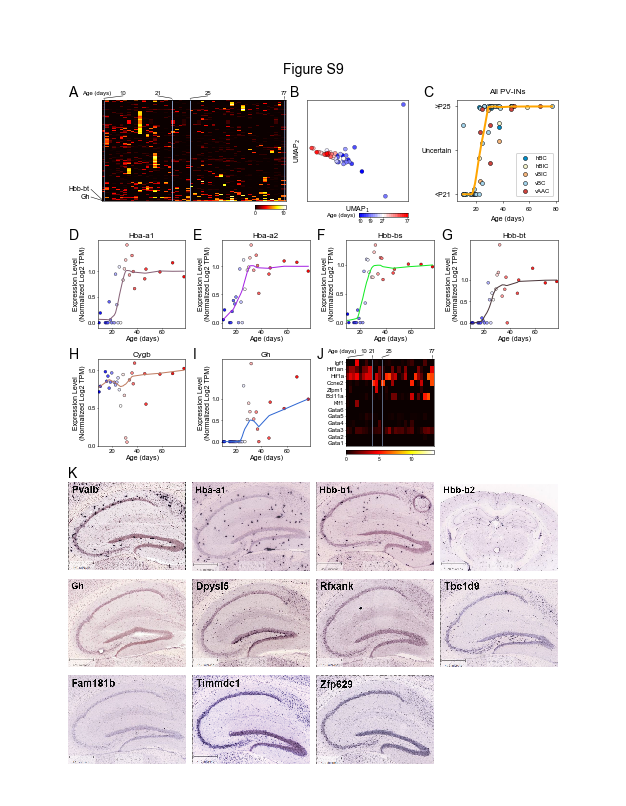

CPU times: user 7.32 s, sys: 1.06 s, total: 8.37 s
Wall time: 6.62 s


In [6]:
%%time

generate_supplementary_figure(df_age, gene_colors, df_predict, df_labels)